In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
import ignite
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import string
pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 101)
np.random.seed(123)
torch.manual_seed(123)
#https://www.analyticsvidhya.com/blog/2019/01/guide-pytorch-neural-networks-case-studies/

Using TensorFlow backend.


In [99]:
df = pd.read_csv('PBP - 2016 - Week 1.csv')
# week2 = pd.read_csv('PBP - 2016 - Week 2.csv')

# df = pd.concat([week1,week2],ignore_index=True)

In [100]:
df = df.dropna()

In [101]:
def getDriveResult(driveId, gameId, df):
    final = df.query('driveIndex == @driveId & gameId == @gameId').iloc[[-1]]
    return final['type'].values[0]

In [102]:
for index,row in df.iterrows():
    df.at[index,'result'] = getDriveResult(row['driveIndex'], row['gameId'], df)

In [103]:
df.head()

,gameId,year,week,homeId,homeTeam,homeAbbr,awayId,awayTeam,awayAbbr,driveIndex,playIndex,offenseId,offenseTeam,offenseAbbr,defenseId,defenseTeam,defenseAbbr,homeScore,awayScore,quarter,clock,wallclock,type,down,distance,yardLine,yardsGained,endYardLine,description,result
0,400868876,2016,1,239,Baylor,BAY,2466,Northwestern St,NWST,0,0,239,Baylor,BAY,2466,Northwestern St,NWST,0,0,1,15:00,2016-09-03T06:36:41Z,Kickoff,1,10,35,10,86,"Drew Galitz kickoff for 61 yds , Shakeir Ryan ...",Punt
1,400868876,2016,1,239,Baylor,BAY,2466,Northwestern St,NWST,0,1,2466,Northwestern St,NWST,239,Baylor,BAY,0,0,1,14:55,2016-09-03T06:38:11Z,Timeout,1,10,86,0,86,"Timeout NORTHWESTERN ST, clock 14:55",Punt
2,400868876,2016,1,239,Baylor,BAY,2466,Northwestern St,NWST,0,2,2466,Northwestern St,NWST,239,Baylor,BAY,0,0,1,14:55,2016-09-03T06:38:11Z,Rush,1,10,86,-1,87,De'Mard Llorens run for a loss of 1 yard to th...,Punt
3,400868876,2016,1,239,Baylor,BAY,2466,Northwestern St,NWST,0,3,2466,Northwestern St,NWST,239,Baylor,BAY,0,0,1,14:55,2016-09-03T06:38:11Z,Rush,2,11,87,8,79,De'Mard Llorens run for 8 yds to the NWSt 21,Punt
4,400868876,2016,1,239,Baylor,BAY,2466,Northwestern St,NWST,0,4,2466,Northwestern St,NWST,239,Baylor,BAY,0,0,1,14:55,2016-09-03T06:38:11Z,Rush,3,3,79,0,79,De'Mard Llorens run for no gain to the NWSt 21,Punt


In [104]:
df['result'].unique()

array(['Punt', 'Rushing Touchdown', 'Field Goal Good',
       'Passing Touchdown', 'Pass Incompletion', 'End of Half',
       'Fumble Recovery (Opponent)', 'End of Game', 'Field Goal Missed',
       'Penalty', 'Pass Interception Return', 'Blocked Field Goal',
       'Defensive 2pt Conversion', 'Rush', 'End Period', 'Pass Reception',
       'Timeout', 'Sack', 'Interception Return Touchdown',
       'Fumble Recovery (Own)', 'Kickoff', 'Kickoff Return Touchdown',
       'Safety', 'Punt Return Touchdown', 'Blocked Punt',
       'Fumble Return Touchdown'], dtype=object)

In [105]:
for i in df['result'].unique():
    print(i)
    print(df.query('result == @i').size)

Punt
170100
Rushing Touchdown
63570
Field Goal Good
54450
Passing Touchdown
62220
Pass Incompletion
11700
End of Half
14550
Fumble Recovery (Opponent)
12270
End of Game
13860
Field Goal Missed
19380
Penalty
2850
Pass Interception Return
19440
Blocked Field Goal
2370
Defensive 2pt Conversion
300
Rush
13980
End Period
3870
Pass Reception
4140
Timeout
1140
Sack
7140
Interception Return Touchdown
2490
Fumble Recovery (Own)
1080
Kickoff
240
Kickoff Return Touchdown
90
Safety
930
Punt Return Touchdown
180
Blocked Punt
750
Fumble Return Touchdown
300


In [106]:
df['description'] = df['description'].str.replace('[^\w\s]','')
df['description'] = df['description'].str.replace('[{}]'.format(string.punctuation), '')
df['result'] = df['result'].str.replace('[^\w\s]','')

In [107]:
def makeTrainColumn(down, distance, yardline, description, quarter, clock):
    return str(down) + ' ' + str(distance) + ' ' + str(yardline) + ' ' + str(quarter) + ' ' +str(clock) +' ' + str(description)

In [108]:
for index,row in df.iterrows():
    df.at[index,'train'] = makeTrainColumn(row['down'], row['distance'], row['yardLine'], row['description'], row['quarter'], row['clock'])

In [109]:
df.head()

,gameId,year,week,homeId,homeTeam,homeAbbr,awayId,awayTeam,awayAbbr,driveIndex,playIndex,offenseId,offenseTeam,offenseAbbr,defenseId,defenseTeam,defenseAbbr,homeScore,awayScore,quarter,clock,wallclock,type,down,distance,yardLine,yardsGained,endYardLine,description,result,train
0,400868876,2016,1,239,Baylor,BAY,2466,Northwestern St,NWST,0,0,239,Baylor,BAY,2466,Northwestern St,NWST,0,0,1,15:00,2016-09-03T06:36:41Z,Kickoff,1,10,35,10,86,Drew Galitz kickoff for 61 yds Shakeir Ryan r...,Punt,1 10 35 1 15:00 Drew Galitz kickoff for 61 yds...
1,400868876,2016,1,239,Baylor,BAY,2466,Northwestern St,NWST,0,1,2466,Northwestern St,NWST,239,Baylor,BAY,0,0,1,14:55,2016-09-03T06:38:11Z,Timeout,1,10,86,0,86,Timeout NORTHWESTERN ST clock 1455,Punt,1 10 86 1 14:55 Timeout NORTHWESTERN ST clock ...
2,400868876,2016,1,239,Baylor,BAY,2466,Northwestern St,NWST,0,2,2466,Northwestern St,NWST,239,Baylor,BAY,0,0,1,14:55,2016-09-03T06:38:11Z,Rush,1,10,86,-1,87,DeMard Llorens run for a loss of 1 yard to the...,Punt,1 10 86 1 14:55 DeMard Llorens run for a loss ...
3,400868876,2016,1,239,Baylor,BAY,2466,Northwestern St,NWST,0,3,2466,Northwestern St,NWST,239,Baylor,BAY,0,0,1,14:55,2016-09-03T06:38:11Z,Rush,2,11,87,8,79,DeMard Llorens run for 8 yds to the NWSt 21,Punt,2 11 87 1 14:55 DeMard Llorens run for 8 yds t...
4,400868876,2016,1,239,Baylor,BAY,2466,Northwestern St,NWST,0,4,2466,Northwestern St,NWST,239,Baylor,BAY,0,0,1,14:55,2016-09-03T06:38:11Z,Rush,3,3,79,0,79,DeMard Llorens run for no gain to the NWSt 21,Punt,3 3 79 1 14:55 DeMard Llorens run for no gain ...


In [110]:
df['train'] = df['train'].str.replace('[^\w\s]','')
df['train'] = df['train'].str.replace('[{}]'.format(string.punctuation), '')
df['result'] = df['result'].str.replace('[^\w\s]','')

In [111]:
x_train = df['train']
y_train = df['result']

x_train = x_train.values
y_train = y_train.values

## Tokens

In [112]:
## create tokens 
tokenizer = keras.preprocessing.text.Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [113]:
## ensure that all the data is actually text
new_x_train = []
for i in x_train:
    new_x_train.append(str(i))
    
x_train = new_x_train


## ensure that all the data is actually text
new_y_train = []
for i in y_train:
    new_y_train.append(str(i))
    
y_train = new_y_train

In [114]:
## convert texts to padded sequences 
x_train = tokenizer.texts_to_sequences(x_train)
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen = 70)

In [115]:
EMBEDDING_FILE = 'glove.840B.300d.txt'

embeddings_index = {}
for i, line in enumerate(open(EMBEDDING_FILE, encoding='utf8')):
    val = line.split()
    embeddings_index[val[0]] = np.asarray(val[1:], dtype='float32')
    


ValueError: could not convert string to float: '.'

In [116]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [117]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        ## Embedding Layer, Add parameter 
        self.embedding = nn.Embedding(2000, embedding_matrix.size) 
        et = torch.tensor(embedding_matrix, dtype=torch.float32)
        self.embedding.weight = nn.Parameter(et)
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = nn.Dropout2d(0.1)
        self.lstm = nn.LSTM(300, 40)        
        self.linear = nn.Linear(40, df['result'].unique().size)
        self.out = nn.Linear(df['result'].unique().size, df['result'].unique().size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h_embedding = self.embedding(x)        
        h_lstm, _ = self.lstm(h_embedding)
        max_pool, _ = torch.max(h_lstm, 1)        
        linear = self.relu(self.linear(max_pool))
        out = self.out(linear)
        return out
    
model = Model()

In [118]:
## create training and validation split 
split_size = int(0.8 * len(df))
index_list = list(range(len(df)))
train_idx, valid_idx = index_list[:split_size], index_list[split_size:]

In [119]:
y_tr_prep = []
for result in y_train:
    i = 0
    for type in df['result'].unique():
        if(result == type):
            y_tr_prep.append(i)
        i+=1
            
            
new_prep = []
for i in train_idx:
    new_prep.append(y_tr_prep[i])
y_tr_prep = new_prep



In [120]:
y_valid_prep = []
for index,row in df.iterrows():
    i = 0
    for type in df['result'].unique():
        if(result == type):
            y_valid_prep.append(i)
        i+=1

print(len(new_prep))


new_prep = []
for i in valid_idx:
    new_prep.append(y_valid_prep[i])
    
y_valid_prep = new_prep

12890


In [121]:
## create iterator objects for train and valid datasets
x_tr = torch.tensor(x_train[train_idx], dtype=torch.long)
y_tr = torch.tensor(y_tr_prep, dtype=torch.float32)
train = TensorDataset(x_tr, y_tr)

## Just trying to get a good weight
test = torch.tensor(y_tr_prep, dtype=torch.int)
print(test)
class_sample_count = np.unique(test, return_counts=True)[1]
print(class_sample_count)
weight = 1. / class_sample_count

print(weight)
samples_weight = weight[test]
print(len(samples_weight))



trainloader = torch.utils.data.DataLoader(train, batch_size=1,sampler=torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight)))

x_val = torch.tensor(x_train[valid_idx], dtype=torch.long)
y_val = torch.tensor(y_valid_prep, dtype=torch.float32)
valid = TensorDataset(x_val, y_val)
validloader = torch.utils.data.DataLoader(valid, batch_size=1)





tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.int32)
[4615 1649 1419 1604  348  392  348  380  564   73  501   79   10  344
   99  108   25  176   70   25    7    3   31    6   14]
[2.16684724e-04 6.06428138e-04 7.04721635e-04 6.23441397e-04
 2.87356322e-03 2.55102041e-03 2.87356322e-03 2.63157895e-03
 1.77304965e-03 1.36986301e-02 1.99600798e-03 1.26582278e-02
 1.00000000e-01 2.90697674e-03 1.01010101e-02 9.25925926e-03
 4.00000000e-02 5.68181818e-03 1.42857143e-02 4.00000000e-02
 1.42857143e-01 3.33333333e-01 3.22580645e-02 1.66666667e-01
 7.14285714e-02]
12890


In [122]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [128]:
for epoch in range(30):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_function(outputs, labels.long())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

[1,  2000] loss: 1.130
[1,  4000] loss: 1.092
[1,  6000] loss: 1.088
[1,  8000] loss: 1.115
[1, 10000] loss: 1.078
[1, 12000] loss: 1.130
[2,  2000] loss: 1.118
[2,  4000] loss: 1.103
[2,  6000] loss: 1.091
[2,  8000] loss: 1.119
[2, 10000] loss: 1.109
[2, 12000] loss: 1.040
[3,  2000] loss: 1.190
[3,  4000] loss: 1.090
[3,  6000] loss: 1.107
[3,  8000] loss: 1.001
[3, 10000] loss: 1.114
[3, 12000] loss: 1.135
[4,  2000] loss: 1.171
[4,  4000] loss: 1.091
[4,  6000] loss: 1.035
[4,  8000] loss: 1.038
[4, 10000] loss: 1.054
[4, 12000] loss: 1.105
[5,  2000] loss: 1.118
[5,  4000] loss: 1.135
[5,  6000] loss: 1.100
[5,  8000] loss: 1.126
[5, 10000] loss: 1.128
[5, 12000] loss: 1.101
[6,  2000] loss: 1.116
[6,  4000] loss: 1.104
[6,  6000] loss: 1.054
[6,  8000] loss: 1.141
[6, 10000] loss: 1.081
[6, 12000] loss: 1.131
[7,  2000] loss: 1.105
[7,  4000] loss: 1.087
[7,  6000] loss: 1.057
[7,  8000] loss: 1.095
[7, 10000] loss: 1.047
[7, 12000] loss: 1.074
[8,  2000] loss: 1.053
[8,  4000] 

KeyboardInterrupt: 

In [129]:
total_correct = 0
total_images = 0
preds = np.empty((0,1))
lebs = np.empty((0,1))
confusion_matrix = np.zeros([len(df['result'].unique()),len(df['result'].unique())], int)
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels.long()).sum().item()
        preds = np.append(preds,predicted)
        lebs = np.append(lebs,labels)
        for i, l in enumerate(labels):
            confusion_matrix[int(l.item()), predicted[i].item()] += 1 

print(total_correct)
model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} train plays: {1:.2f}%'.format(total_images, model_accuracy))

8717
Model accuracy on 12890 train plays: 67.63%


In [130]:
total_correct = 0
total_images = 0
preds = np.empty((0,1))
lebs = np.empty((0,1))
confusion_matrix = np.zeros([27,27], int)
with torch.no_grad():
    for data in validloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels.long()).sum().item()
        preds = np.append(preds,predicted)
        lebs = np.append(lebs,labels)
        for i, l in enumerate(labels):
            confusion_matrix[int(l.item()), predicted[i].item()] += 1 

print(total_correct)
model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} train plays: {1:.2f}%'.format(total_images, model_accuracy))

213
Model accuracy on 3223 train plays: 6.61%


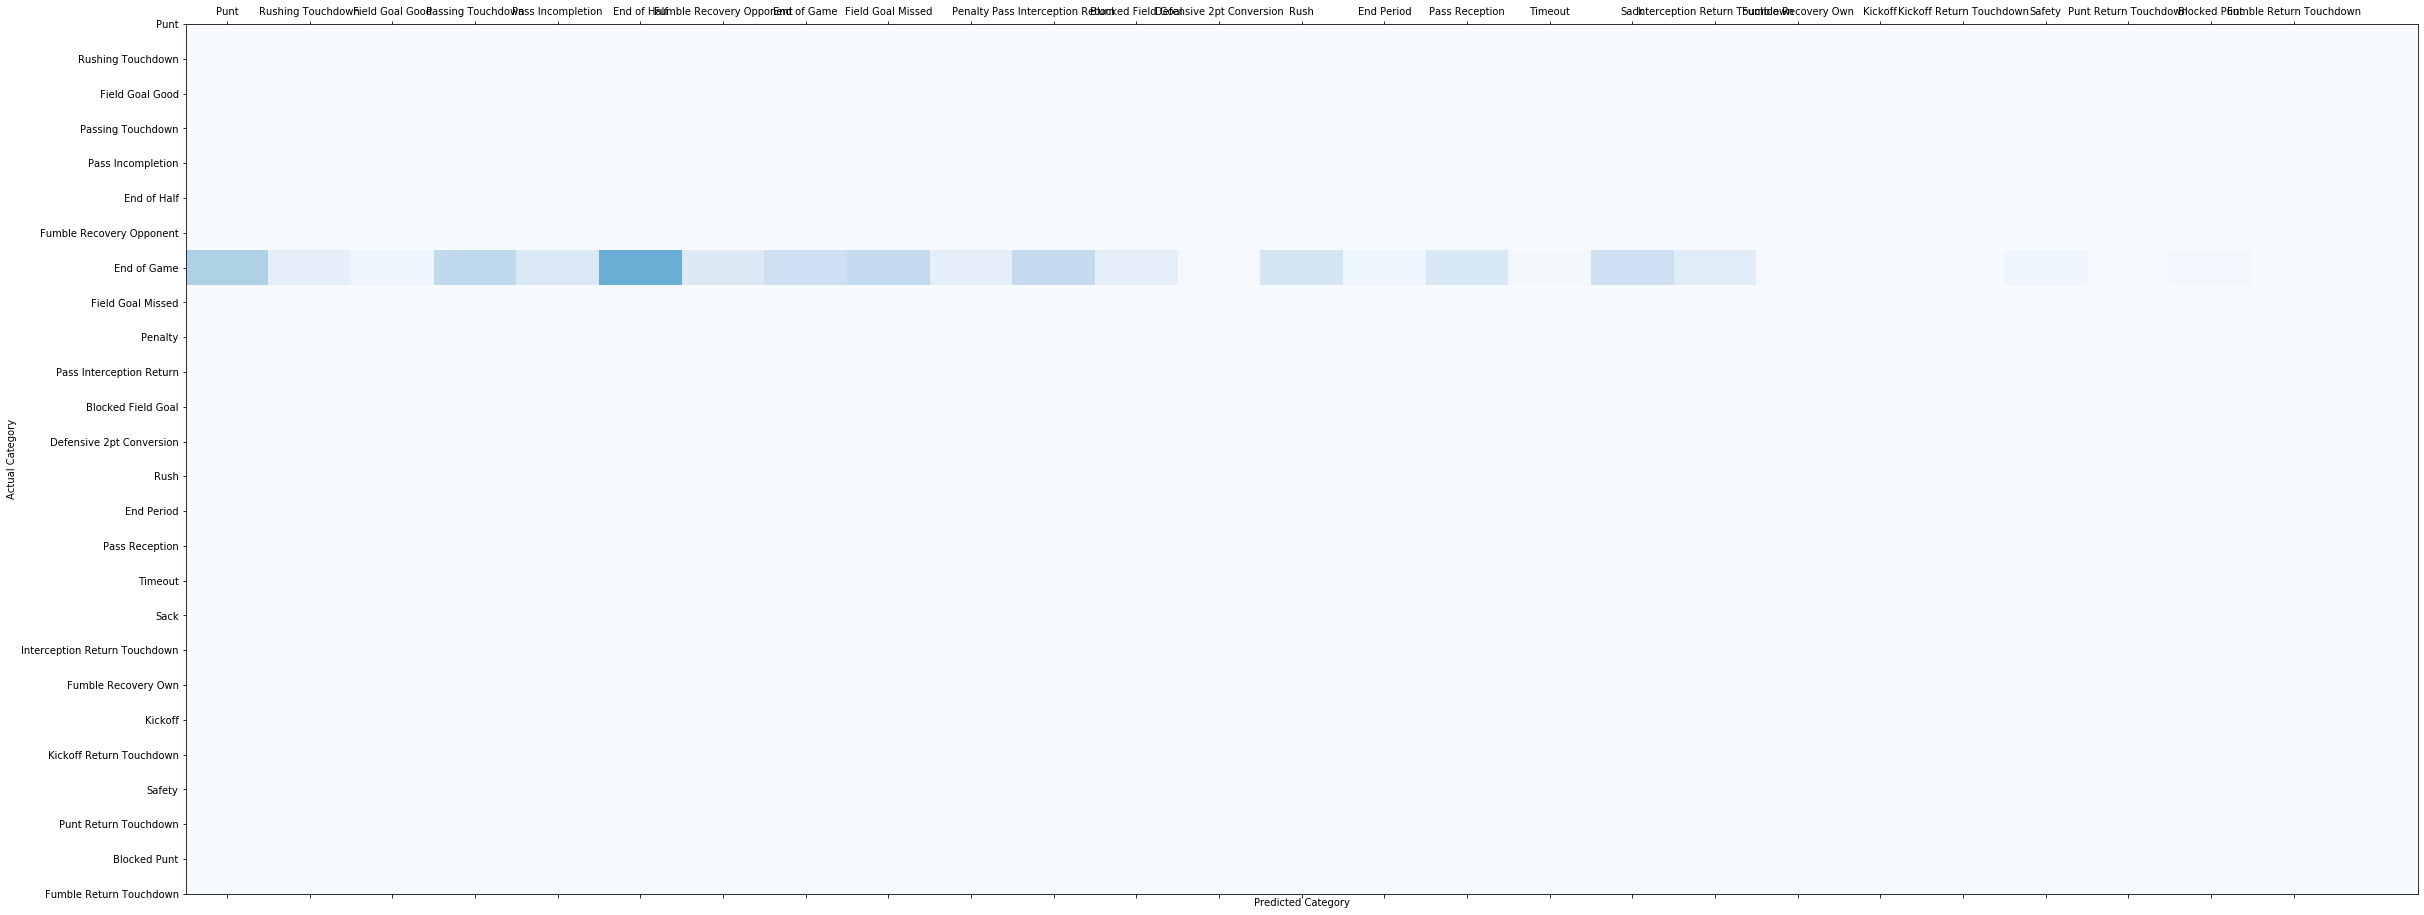

In [131]:
fig, ax = plt.subplots(1,1,figsize=(40,16))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(len(df['result'].unique())), df['result'].unique())
plt.xlabel('Predicted Category')
plt.xticks(range(len(df['result'].unique())), df['result'].unique())
plt.show()

In [132]:
week2 = pd.read_csv('PBP - 2016 - Week 2.csv')

In [133]:
for index,row in week2.iterrows():
    week2.at[index,'result'] = getDriveResult(row['driveIndex'], row['gameId'], week2)

In [134]:
for index,row in week2.iterrows():
    week2.at[index,'train'] = makeTrainColumn(row['down'], row['distance'], row['yardLine'], row['description'], row['quarter'], row['clock'])

In [135]:
week2['train'] = week2['train'].str.replace('[^\w\s]','')
week2['train'] = week2['train'].str.replace('[{}]'.format(string.punctuation), '')
week2['result'] = week2['result'].str.replace('[^\w\s]','')

In [136]:
check_x = week2['train']
check_y = week2['result']

In [145]:
## create training and validation split 
split_size = int(0.8 * len(df))
index_list = list(range(len(df)))
train_idx, valid_idx = index_list[:split_size], index_list[split_size:]

In [137]:
## ensure that all the data is actually text
new_x_train = []
for i in check_x:
    new_x_train.append(str(i))
    
check_x = new_x_train


## ensure that all the data is actually text
new_y_train = []
for i in check_y:
    new_y_train.append(str(i))
    
check_y = new_y_train

In [138]:
## convert texts to padded sequences 
check_x = tokenizer.texts_to_sequences(check_x)
check_x = keras.preprocessing.sequence.pad_sequences(check_x, maxlen = 70)

In [139]:
len(check_x)

13548

In [140]:
len(check_y)

13548

In [143]:
len(y_tr_prep)

13547

In [146]:
y_tr_prep = []
for result in check_y:
    i = 0
    for type in df['result'].unique():
        if(result == type):
            y_tr_prep.append(i)
        i+=1
            
            
new_prep = []
for i in train_idx:
    new_prep.append(y_tr_prep[i])
check_y = new_prep



In [92]:
len(y_tr_prep)

13547

In [151]:
x_tr = torch.tensor(check_x[train_idx], dtype=torch.long)
y_tr = torch.tensor(check_y, dtype=torch.float32)
test = TensorDataset(x_tr, y_tr)
testLoader = torch.utils.data.DataLoader(test, batch_size=1,sampler=torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight)))


In [152]:
total_correct = 0
total_images = 0
preds = np.empty((0,1))
lebs = np.empty((0,1))
confusion_matrix = np.zeros([len(df['result'].unique()),len(df['result'].unique())], int)
with torch.no_grad():
    for data in testLoader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels.long()).sum().item()
        preds = np.append(preds,predicted)
        lebs = np.append(lebs,labels)
        for i, l in enumerate(labels):
            confusion_matrix[int(l.item()), predicted[i].item()] += 1 

print(total_correct)
model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} train plays: {1:.2f}%'.format(total_images, model_accuracy))

1874
Model accuracy on 12890 train plays: 14.54%


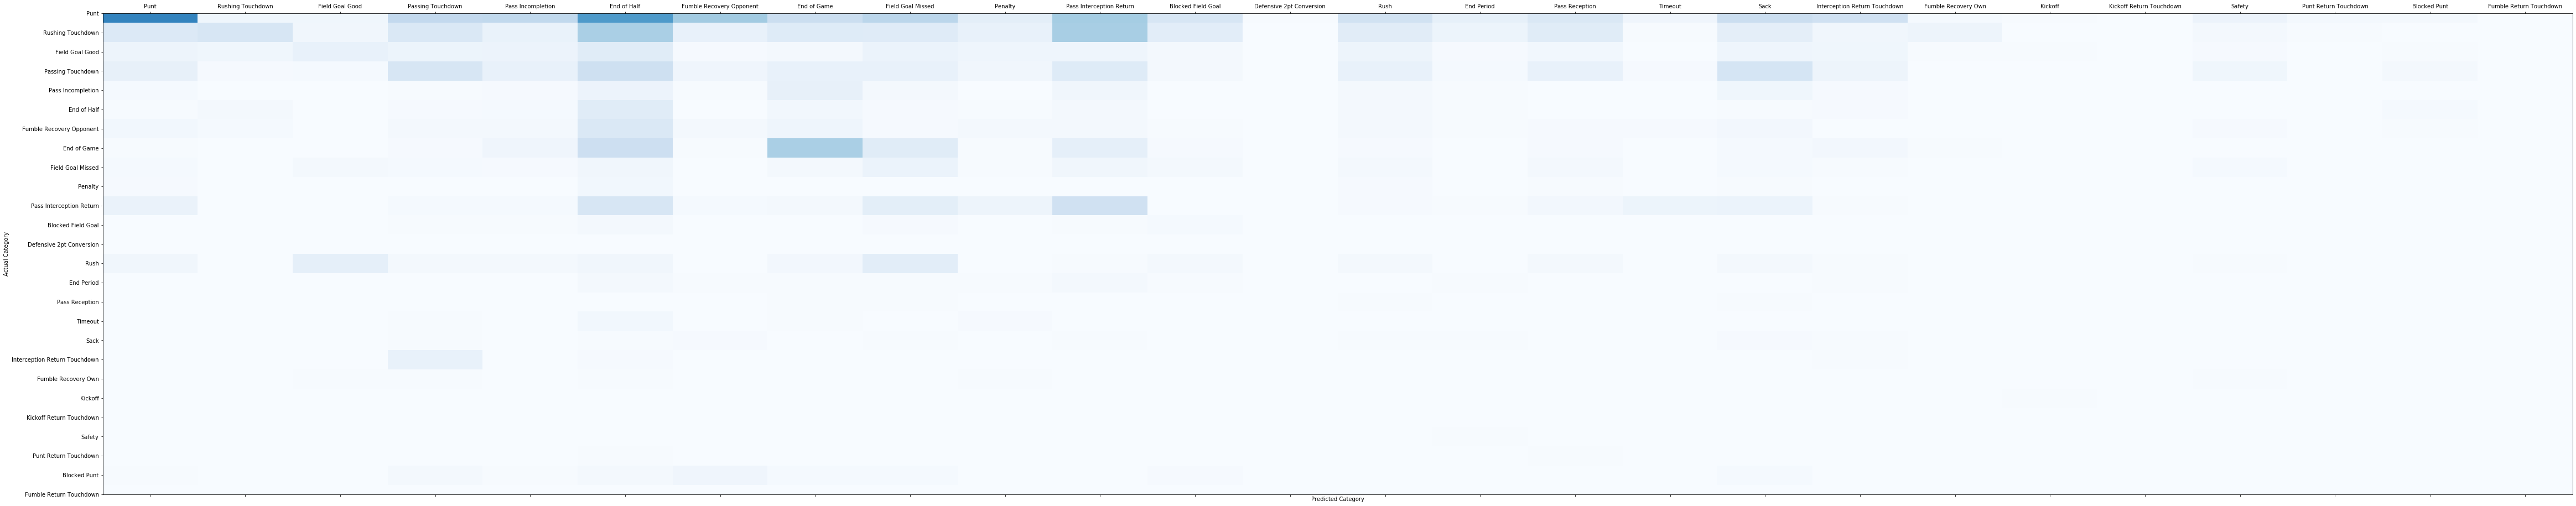

In [154]:
fig, ax = plt.subplots(1,1,figsize=(80,16))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(len(df['result'].unique())), df['result'].unique())
plt.xlabel('Predicted Category')
plt.xticks(range(len(df['result'].unique())), df['result'].unique())
plt.show()